<span style="background-color: yellow; color: black; font-size: 26px;">**Before you start, make sure you ran the *setup* notebook and have your GEE account.**</span>

You can find the *setup* notebook in the link: https://github.com/soilwater/precisionag-workshop-2024/blob/main/setup_python_geospatial_analysis.ipynb

# Create Field Management Zones using NDVI images

In this tutorial you will learn how to:

- Find, access, and download products from Google Earth Engine
- Compute NDVI from image bands 
- Load custom field boundaries in vector format
- Plot raster files
- Stack raster files to generate space-time arrays
- Learn how to merge multiple NDVI images using the Mean Relative Difference concept
- Cluster multiple images to generate field management zones
- Export map of resulting field management zones as prescription maps in Shapefile format

Notebook created by Andres Patrignani and Gabriel da Rocha Hintz - November 2024


### Import necessary modules

Go to Anaconda website to install some of these packages: 

In [10]:
# Import modules
import ee
import glob
import json
import requests
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import colors

from datetime import datetime, timedelta
from scipy.ndimage import gaussian_filter

from sklearn.cluster import BisectingKMeans
from sklearn.impute import SimpleImputer

import rasterio.features
from shapely.geometry import shape # shape creates a Shapely geometry


### Initialize Google Earth Engine

In [12]:
# Authenticate
ee.Authenticate()

# Initialize API
ee.Initialize()

### Create helper functions

In [16]:
def save_gee_to_geotiff(ee_image, filename, crs, scale, geom, bands=[]):
    """Function to save geotiff images from GEE into local hard drive."""

    image_url = ee_image.getDownloadUrl({'region': geom,'scale':scale, 
                                         'bands': bands,
                                         'crs': f'EPSG:{crs}', 
                                         'format': 'GEO_TIFF'})
    
    # Request data using URL and save data as a new GeoTiff file
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
            print(f"Saved image {filename}")
    else:
        print("Failed to download image")


def array_to_df(arr):
    """Function to convert list into Pandas dataframe"""
    
    df = pd.DataFrame(arr[1:])
    df.columns = arr[0]
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    return df


In [18]:
# Set format of axes without offset in the form of scientific notation
plt.rcParams['axes.formatter.useoffset'] = False


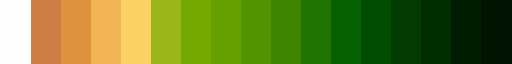

In [20]:
# Create our own colormap
hex_palette = ['#FEFEFE','#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901',
             '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01',
             '#012E01', '#011D01', '#011301']


# Use the built-in ListedColormap function to do the conversion
ndvi_cmap = colors.ListedColormap(hex_palette)
# ndvi_cmap.set_bad

### Define area of interest

We will use the boundaries of an actual farmer production field near Gypsum, KS.

In [22]:
# Read field boundary with Geopandas
field_bnd = gpd.read_file('mortimers_bnd.geojson')
field_bnd

,geometry
0,"POLYGON ((-97.43239 38.71092, -97.43281 38.712..."


In [34]:
# How to access documentation/help
#field_bnd.plot?

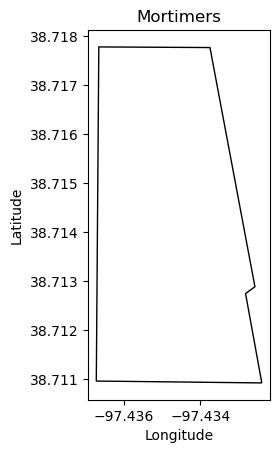

In [30]:
# Visualize field boundaries
fig, ax = plt.subplots()
field_bnd.plot(ax=ax, facecolor='None', edgecolor='k')
ax.set_title('Mortimers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


In [44]:
# Get JSON format of GeoDataframe
# Note that .to_json() gives us a string, so we use the json module to create a proper json object
field_bnd_json = json.loads( field_bnd.to_json() )
field_bnd_json

# Define the region of interest (roi) in GEE as a ee.Geometry
roi = ee.Geometry( field_bnd_json['features'][0]['geometry'] )

# Create mask in GEE for field
mask = ee.Image.constant(1).clip(roi).mask()


In [46]:
# Get centroid of GEE geometry (note that this is of type: Point
field_centroid = roi.centroid().getInfo()
print(field_centroid)

{'type': 'Point', 'coordinates': [-97.43482229076969, 38.71414271696167]}


### Get NDVI timeseries to inspect growing season trend

To inspect some of the temporal variability and help us identify the period to download some data for our project, let's plot some NDVI time series for the centroid (you can do this foy any point within the field).

We will use the following GEE product: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1

In [50]:
# Define start and end dates
start_date = '2020-01-01'
end_date = '2023-12-31'

#type(start_date)

str

In [56]:
# Get collection for Modis-Terra 16-day composite at 250-meter resolution
terra = ee.ImageCollection('MODIS/061/MOD13Q1').filterDate(start_date, end_date)
ndvi = terra.select('NDVI')
poi_ndvi = ndvi.getRegion(roi.centroid(), scale=250).getInfo()
df_poi_ndvi = array_to_df(poi_ndvi)

df_poi_ndvi.head(5)


,id,longitude,latitude,time,NDVI
0,2020_01_01,-97.434644,38.71402,2020-01-01,4582
1,2020_01_17,-97.434644,38.71402,2020-01-17,4417
2,2020_02_02,-97.434644,38.71402,2020-02-02,4105
3,2020_02_18,-97.434644,38.71402,2020-02-18,4364
4,2020_03_05,-97.434644,38.71402,2020-03-05,7065


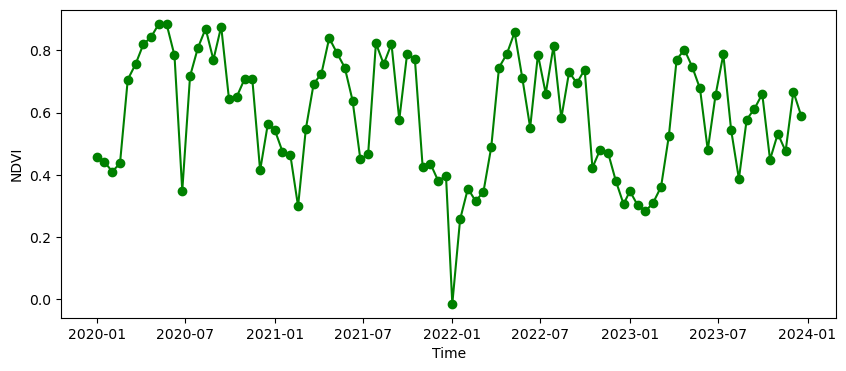

In [60]:
# Convert array into dataframe
plt.figure(figsize=(10,4))
plt.plot(df_poi_ndvi['time'], 
         df_poi_ndvi['NDVI']*0.0001, 
         linestyle='-', 
         marker='o', # circular marker
         color='green')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.show()


In [ ]:
# Create figure to visualize time series


### Download Sentinel data

First we are going to request the available image dates within a user-define period of time. Then we will download a few of the images in the list so that the code runs within a short period of time.

For this part we will use a product from Sentinel that has some cloud information associated with it that will allow us to filter out images during clouy days. The product link is: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED

In [62]:
# Re-define start and end dates based on time series
start_date = '2023-01-01'
end_date = '2023-12-01'


In [72]:
# Select Sentinel 2 image collection
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate(start_date, end_date).filterBounds(roi).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Get the list of available image dates
get_date = lambda image: ee.Image(image).date().format('YYYY-MM-dd')

collection_dates = collection.toList( collection.size() ).map(get_date).getInfo()
collection_dates


['2023-01-09',
 '2023-01-19',
 '2023-01-27',
 '2023-02-03',
 '2023-02-11',
 '2023-02-13',
 '2023-02-28',
 '2023-03-03',
 '2023-04-02',
 '2023-04-12',
 '2023-04-17',
 '2023-04-29',
 '2023-05-07',
 '2023-05-12',
 '2023-05-17',
 '2023-06-06',
 '2023-06-13',
 '2023-06-18',
 '2023-06-26',
 '2023-07-11',
 '2023-07-23',
 '2023-07-26',
 '2023-08-07',
 '2023-08-15',
 '2023-08-20',
 '2023-08-25',
 '2023-08-27',
 '2023-08-30',
 '2023-08-30',
 '2023-09-01',
 '2023-09-04',
 '2023-09-06',
 '2023-09-26',
 '2023-09-29',
 '2023-10-01',
 '2023-10-04',
 '2023-10-09',
 '2023-10-11',
 '2023-10-16',
 '2023-10-19',
 '2023-10-21',
 '2023-11-10',
 '2023-11-13',
 '2023-11-18',
 '2023-11-28']

In [80]:
# Select a subset of the collection dates to download
selected_dates = collection_dates[::3]

# Download each image
for date in selected_dates:

    # Define dates
    start_date = date
    end_date = (datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    
    # Request image
    image = collection.filterDate(start_date, end_date).first().select(['B8', 'B4'])
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI').mask(mask)

    save_gee_to_geotiff(ndvi, 
                        f'ndvi_data_live/ndvi_{start_date}.tif',
                       crs=4326,
                       scale=10,
                       geom=roi)


#print(start_date)
#datetime.strptime(start_date, '%Y-%m-%d')

Saved image ndvi_data_live/ndvi_2023-01-09.tif
Saved image ndvi_data_live/ndvi_2023-02-03.tif
Saved image ndvi_data_live/ndvi_2023-02-28.tif
Saved image ndvi_data_live/ndvi_2023-04-12.tif
Saved image ndvi_data_live/ndvi_2023-05-07.tif
Saved image ndvi_data_live/ndvi_2023-06-06.tif
Saved image ndvi_data_live/ndvi_2023-06-26.tif
Saved image ndvi_data_live/ndvi_2023-07-26.tif
Saved image ndvi_data_live/ndvi_2023-08-20.tif
Saved image ndvi_data_live/ndvi_2023-08-30.tif
Saved image ndvi_data_live/ndvi_2023-09-04.tif
Saved image ndvi_data_live/ndvi_2023-09-29.tif
Saved image ndvi_data_live/ndvi_2023-10-09.tif
Saved image ndvi_data_live/ndvi_2023-10-19.tif
Saved image ndvi_data_live/ndvi_2023-11-13.tif


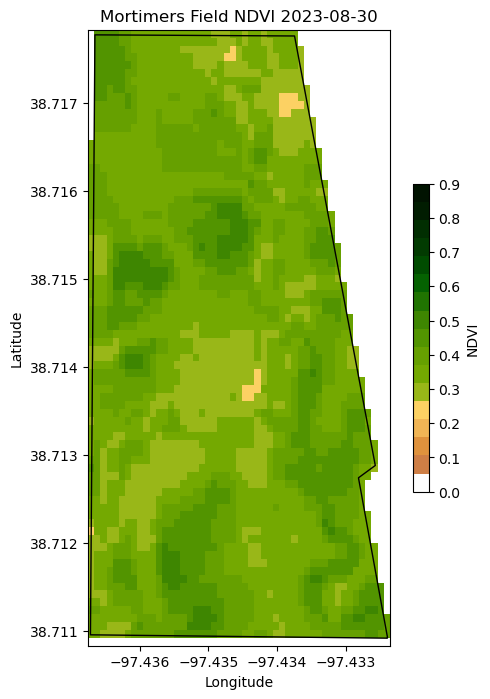

In [98]:
# Read one image to inspect data
plot_date = '2023-08-30'
da = xr.load_dataarray(f'ndvi_data_live/ndvi_{plot_date}.tif')

# Get number of rows and columns for later use

# Visualize map for specific date
fig, ax = plt.subplots(figsize=(6,8))
da.plot(ax=ax, cmap=ndvi_cmap, vmin=0.0, vmax=0.9, 
        cbar_kwargs={'label':'NDVI',
                     'shrink':0.5})
field_bnd.plot(ax=ax, facecolor='None')
ax.set_title(f'Mortimers Field NDVI {plot_date}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig(f'figures/ndvi_{plot_date}.jpg', dpi=300)
plt.show()


### Create space-time data array using all the images

In [ ]:
# Read all image names


In [ ]:
# Create DataArray


In [ ]:
# Plot all of them


### Access and select data within DataArray

In [ ]:
# Plot single image by date


In [ ]:
# Only areas with specific NDVI


In [ ]:
# Plot time series


### Compute relative difference

For each NDVI layer we will normalize the values by first subtracting the mean, and then dividing by the mean. This was we will obtain a new grid showing areas of the field that have more or less biomass than teh field average.

$$ RD = \frac{NDVI - \overline{NDVI}}{\overline{NDVI}}$$


In [ ]:
# Create lambda function to compute RD


In [ ]:
# Compute relative difference


In [ ]:
# Create data array


In [ ]:
# Compute mean relative difference



In [ ]:
# Plot mean relative difference



### Create management zones

We will use clustering analysis to find homogeneous management zones. During clustering, each column represents a different feature (NDVI date, or any other variable) and rows represent reps or observations (in our case each pixel of the field).

In [ ]:
# Input data using MRD

# Imputing missing data


In [ ]:
# Clustering (this will result in integer labels)

# Smooth clusters using Gaussian filter


In [ ]:
# Create DataArray with resulting clusters, which the new management zones


# Restore NaN cells


# Plot management zones


In [ ]:
# Create a version where each cluster is represented by the median MRD


In [ ]:
# Show mapped clusters using MRD values


### Vectorize resulting raster management zones

In [ ]:
# Create empty arrays to save polygons for each cluster and their MRD value

# Create a GeoDataFrame with the polygons and their cluster labels


In [ ]:
# Plot mapped clusters


In [ ]:
# Visualize interactive map


In [ ]:
# Export shapefile to use as a prescription map
